In [1]:
from carla import Benchmark
from IPython.display import display
import carla.evaluation.catalog as evaluation_catalog
from carla.data.catalog import OnlineCatalog
from carla.models.catalog import MLModelCatalog
from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog
import shap 
from sklearn.preprocessing import OrdinalEncoder
from carla.data.causal_model import CausalModel
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from carla.data.catalog import CsvCatalog
import numpy as np 

import warnings
warnings.filterwarnings("ignore")

/home/jacqueline/.local/share/virtualenvs/CARLA-koH0yuP4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-koH0yuP4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-koH0yuP4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [2]:
scm = CausalModel("credit")

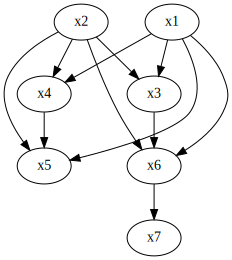

In [3]:
scm.cgm.draw()

In [4]:

dataset = scm.generate_dataset(1000)
dataset.df.to_csv('credit_synthetic.csv',index=False)
display(dataset.df)

,label,x1,x2,x3,x4,x6,x5,x7
0,0.0,1.0,-3.778779,0.034858,-2.805858,2.668190,0.625062,1.603405
1,1.0,1.0,4.761251,-0.126113,4.285616,4.856163,5.129414,-0.186572
2,1.0,0.0,10.503982,-0.044976,-2.304842,3.434988,-6.245169,9.046606
3,0.0,0.0,-0.584635,-0.260317,-1.433105,1.633967,-6.160381,2.629664
4,0.0,1.0,-10.542046,0.066224,-2.835842,-1.511927,-2.733604,-1.958705
...,...,...,...,...,...,...,...,...
995,0.0,1.0,-12.834067,-0.187268,1.447568,-1.002346,1.124198,-5.999044
996,0.0,0.0,-2.405122,-0.046149,-0.298058,0.047583,2.599358,-0.879818
997,0.0,1.0,5.169345,0.140594,-2.141767,2.587424,-1.092978,-6.545550
998,0.0,0.0,3.573549,0.062057,2.471233,-2.356411,0.429956,-8.093422


In [5]:
'''Build Dataset for Wachter'''
import pandas as pd
# Load Data 
dataframe = pd.read_csv('./credit_synthetic.csv')
continuous = dataframe.drop(columns=['label']).columns

dataset = CsvCatalog(file_path="credit_synthetic.csv",
                     continuous=continuous,
                     categorical=[],
                     immutables=[],
                     target='label')

In [6]:
#Model 

training_params = {"lr": 0.01, "epochs": 3, "batch_size": 16, "hidden_size": [18, 9, 2]}

ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
)
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)


balance on test set 0.4533333333333333, balance on test set 0.432
Epoch 0/2
----------
train Loss: 0.6928 Acc: 0.5307

test Loss: 0.6860 Acc: 0.5680

Epoch 1/2
----------
train Loss: 0.6900 Acc: 0.5467

test Loss: 0.6869 Acc: 0.5680

Epoch 2/2
----------
train Loss: 0.6903 Acc: 0.5467

test Loss: 0.6842 Acc: 0.5680



In [7]:
from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog

factuals = predict_negative_instances(ml_model, dataset.df)
test_factual = factuals.iloc[:25]

display(test_factual)

,label,x1,x2,x3,x4,x6,x5,x7
0,0.0,1.0,0.258491,0.575842,0.660767,0.604923,0.623897,0.590649
1,1.0,1.0,0.370877,0.360361,0.910849,0.738596,0.783254,0.540290
2,1.0,0.0,0.446451,0.468973,0.678435,0.651770,0.380839,0.800054
3,0.0,0.0,0.300526,0.180711,0.709177,0.541737,0.383838,0.619521
4,0.0,1.0,0.169487,0.617829,0.659709,0.349540,0.505072,0.490433
5,1.0,0.0,0.294337,0.479947,0.794926,0.616545,0.417890,0.577137
6,1.0,1.0,0.417354,0.730241,0.912185,0.643195,0.854670,0.737755
7,0.0,1.0,0.025725,0.281687,0.614714,0.241660,0.601157,0.363593
8,0.0,0.0,0.282958,0.313738,0.730356,0.386321,0.631863,0.470692
9,1.0,1.0,0.607330,0.681263,0.689707,0.889225,0.748909,0.689021


In [8]:
hyperparams = {"loss_type": "BCE"}

recourse_method = recourse_catalog.Wachter(ml_model, hyperparams)
cfs = recourse_method.get_counterfactuals(test_factual)


[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]


In [ ]:
def get_pred_from_causal(scm,values,cf_label, mapping_dict):
    #TODO change everything hard coded
    values['target']=cf_label
    def _get_noise_string(node):
        def _get_node_id(node):
            return node[1:]
        if not node[0] == "x":
            raise ValueError
        return "u" + _get_node_id(node)
    exogenous_variables = np.concatenate(
        [
            np.array(values[mapping_dict[node]]).reshape(-1, 1)
            for node in scm.get_topological_ordering("exogenous")
        ],
        axis=1,
    )
    exogenous_variables = pd.DataFrame(
        exogenous_variables, columns=scm.get_topological_ordering("exogenous")
    )

    endogenous_variables = exogenous_variables.copy()
    endogenous_variables = endogenous_variables.rename(
        columns=dict(
            zip(
                scm.get_topological_ordering("exogenous"),
                scm.get_topological_ordering("endogenous"),
            )
        )
    )
    # used later to make sure parents are populated when computing children
    endogenous_variables.loc[:] = np.nan
    for node in scm.get_topological_ordering("endogenous"):
        parents = scm.get_parents(node)
        if endogenous_variables.loc[:, list(parents)].isnull().values.any():
            raise ValueError(
                "parents in endogenous_variables should already be occupied"
            )
        endogenous_variables[node] = scm.structural_equations_np[node](
            exogenous_variables[_get_noise_string(node)],
            *[endogenous_variables[p] for p in parents],
        )
    labels=endogenous_variables['x7'][0]
    return labels

In [ ]:
mapping_dict={ 
    # Gender
      'u1': 'x1',
      # Age
      'u2': 'x2',
      # Education
      'u3': 'x3',
      # Loan amount
      'u4':'x4',
      # Loan duration
      'u5': 'x5',
      # Income
      'u6': 'x6',
      # Savings
      'u7':'x7',
}

In [ ]:
from telnetlib import SE
from carla.data import causal_model
from carla.evaluation import remove_nans
from carla.evaluation.api import Evaluation
class Sematic(Evaluation):
    """
    Semnatic Evaluation Metric.
    Attributes: 
        ml_model: Machine Learning Model
        causal_graph: ground truth causal graph
        mapping_dict: name mapping
    """

    def __init__(self, ml_model, causal_graph,mapping_dict):
        self.ml_model= ml_model
        self.causal_graph=causal_graph
        self.mapping_dict=mapping_dict
    def get_evaluation(self,factuals: np.ndarray, counterfactuals: np.ndarray):
        # generate data 
        cf_label=self.ml_model.predict(np.array(counterfactuals.values).reshape(-1,counterfactuals.values.shape[-1]))
        cf_label=np.argmax(cf_label)
        causal_label=get_pred_from_causal(self.causal_graph,counterfactuals,cf_label, self.mapping_dict)
        #print(cf_label)
        if cf_label ==causal_label:
            return pd.DataFrame([[1]], columns=["semantic"])
        else: 
            return pd.DataFrame([[0]], columns=["semantic"])
'''Histogram Features / true Positive / false Positive'''
# first initialize the benchmarking class by passing
# black-box-model, recourse method, and factuals into it#
results=[]
i=0
#print(factuals.iloc[:20])
for a in range(0, len(factuals.iloc[:20])):
    #print(a)
    if np.any(a != None):
        sem= Sematic(ml_model,scm,mapping_dict)
        #print(factuals.iloc[a])
        results.append( sem.get_evaluation(factuals.iloc[a],cfs.iloc[i])['semantic'][0])
    i=i+1


#benchmark = Benchmark(ml_model, recourse_method, factuals[:20])

# now you can decide if you want to run all measurements
# or just specific ones.
#evaluation_measures = [
#    Sematic(ml_model,scm,mapping_dict)
#]

#results = benchmark.run_benchmark(evaluation_measures)
results


SyntaxError: invalid syntax (3110270345.py, line 40)

In [ ]:
# Box Plot of
mean= np.mean(results['semantics'])
std= np.std(results['semantics'])
print(f'Semantic results {mean} +/- {std}')

TypeError: list indices must be integers or slices, not str

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt 
# Data Distribution
id_comp= np.where(results['semantics'].values==1)
id_not_comp=np.where(results['semantics'].values==0)
cfs_complient=cfs[id_comp]
cfs_not_complient=[id_not_comp]

cfs_complient_predict=np.max(ml_model.predict(np.array(cfs_complient.values).reshape(-1,cfs_complient.values.shape[-1])),axis=1)
#TODO
cfs_not_complient_predict=np.max(ml_model.predict(np.array(cfs_not_complient.values).reshape(-1,cfs_not_complient.values.shape[-1])),axis=1)

df_complient = pd.DataFrame(np.array([cfs_complient_predict,cfs_not_complient_predict]), columns=['complient','not complient'])

In [ ]:
#BoxPlot
boxplot = df_complient.boxplot(column=['complient','not complient'])  

In [ ]:
# Violin Plot 
